# Generating Toy Data/Model and Deploying to AdaFruit EdgeBadge

### Akshay Sridharan
#### Georgia Institute of Technology M.S. in Analytics Practicum Project with GE Research

Problem Statement: Design an anomaly detection workflow to detect anomalous movement using accelerometer readings. Deploy to an AdaFruit EdgeBadge for real-time inference.

### Plan of attack: 

##### Data Generation:
Toy accelerometer data will be loaded in from an AdaFruit EdgeBadge. The data will be sent to the device's serial port using the in-built AdaFruit magic_wand example code. The data will be read into Python from the serial port using pySerial (https://pyserial.readthedocs.io/en/latest/pyserial.html#overview) and further saved to a .csv for easy recreation of the workflow. It will be cleaned and stored using pandas as a multi-variate time series.

##### Data Description:
This data will consist of 3-channel accelerometer readings recorded over a 90 second interval at 25Hz. The first 60 seconds of the data will consist of "normal turbulence". This coincides with a typical, rhythmic movement of the device to synthetically emulate normal operating conditions of a machine (all is working well in our fake machine). The next 30 seconds of the data will consist of "anomalous turbulence". This coincides with an atypical, erratic movement of the device to synthetically emulate anomalous operating conditions of a machine (all is not well in our fake machine).

##### Anomaly Detection Approach:
In order to enact the anomaly detection, an autoencoder approach will be implemented. An autoencoder is a model that simply attempts to recreate the identity function for an input while minimizing the impact of overfitting. A neural network typically accomplishes this by compressing input information in intermediate layers and decompressing information in latter layers to effectively conduct lossy compression and decompression. The model is trained using the training data as both the input and response, thereby training the model to minimize compression loss caused in the smaller node cardinality intermediate layers. Thus, informally, the model is attempting to become quite good at reconstructing "normal turbulence" input signals, and will by design be quite poor at the reconstruction of "anomalous turbulence" input signals.

As this model is trained, a training loss distribution will be calculated. The loss used will be mean absolute error between input and output vectors, for the sake of simplicity. An upper threshold for the "normal turbulence" loss will be identified and used for the anomaly detection step. When streaming test or inference data to the model, normal signals will show low loss below the threshold value, while anomalous signals will lead to loss values above the threshold value. Thus, any loss calculated above the threshold value implies the input signal was anomalous.

In [2]:
!python --versions

unknown option --versions
usage: python [option] ... [-c cmd | -m mod | file | -] [arg] ...
Try `python -h' for more information.


### Importing Necessary Libraries

In [1]:
#Data creation and cleaning
import csv
from time import time
import serial
import pandas as pd
import numpy as np

#Plotting packages
import matplotlib.pyplot as plt
import seaborn as sns

#Modeling
import tensorflow as tf
from tensorflow import keras
from keras.layers import Input, Dropout, Dense, LSTM, TimeDistributed, RepeatVector
from keras.models import Model
from keras import regularizers

#Quantization-Aware training
import tensorflow_model_optimization as tfmot

### Reading in data from serial port
Note: This step is only meant to be run for data generation. For reuse of the exact project data, the following cell may be skipped and the accompanying .csv may just be loaded in i.e. there is no need to rerun this cell unless you would like to create your own data (which requires running the magic_wand AdaFruit example prior to running the following cell).

In [ ]:
#Obtaining data generated by randomized perturbations of accelerometer (shaking EdgeBadge with intentional anomalous shake at the very end for test set)
#Run this cell while running magic_wand example on Adafruit EdgeBadge to generate data then pulling values from Serial port
#Loop ends after samples have been collected

#Serial port will have to be user set and will need to correspond to EdgeBadge serial port value (found in Arduino IDE)
serial_port = '/dev/cu.usbmodem143101'
ser = serial.Serial(serial_port, timeout=1)

f = open("df.csv", "a+")
writer = csv.writer(f, delimiter=',')

#The number of samples will equal the recording frequency (25Hz) multiplied by the duration of the sample (90 seconds)
num_samples = 25*90

for i in range(num_samples):
    s = ser.readline().decode()
    if s != "":
        rows = [float(x) for x in s.split(',')]
        # Insert local time to list's first position
        rows.insert(0, time())
        print(rows)
        writer.writerow(rows)
        f.flush()
    
print("Collection finished!")

### Loading data from .csv

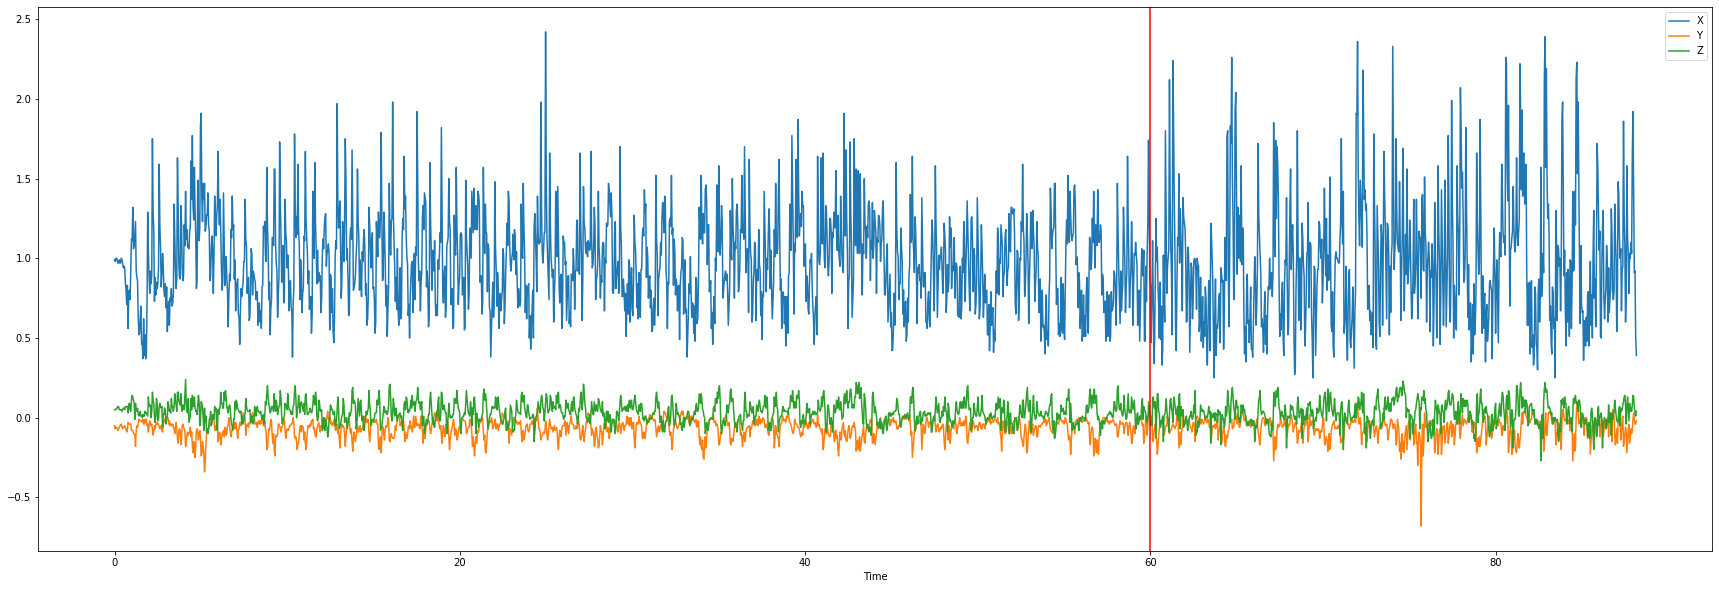

In [2]:
#Reading in raw data
data = pd.read_csv('df.csv', names=['Time', 'X', 'Y', 'Z'])

#Changing time to seconds elapsed
data.iloc[:,0] -= np.min(data.iloc[:,0])

#Displaying plot of accelerometer data across total time period
data.plot(x='Time', y=["X", "Y", 'Z'],
        kind="line", figsize=(30, 10))
plt.axvline(x=60, color='red')
plt.show()

In the above plot, the differences between the baseline 'normal turbulence' between the two increments can be observed, particularly in the X-axis accelerometer readings.

### Creating Train-Test Split and Formatting data

Splitting data into test and train samples. Train-Test split for each increment will be approximately 40-60.

In [3]:
int(0.4*len(data))

900

In [4]:
train = data.iloc[0:int(0.4*len(data)),:]
test = data.iloc[(int(0.4*len(data))):,:]

#Setting time to be index value
traindf = train.set_index("Time", inplace=False)
testdf = test.set_index("Time", inplace=False)

#Converting traindf and testdf to arrays
train = np.array(traindf)
test = np.array(testdf)

#Reshaping data for compatibility with model [samples, timesteps, features]
train = train.reshape(train.shape[0], 1, train.shape[1])
print("Training data shape:", train.shape)
test = test.reshape(test.shape[0], 1, test.shape[1])
print("Test data shape:", test.shape)

Training data shape: (900, 1, 3)
Test data shape: (1350, 1, 3)


In [5]:
def create_dataset(data, train_prop, batch_size):
    #Verify that all data in training set is utilized given the batch size
    assert int(len(data)*train_prop) % batch_size == 0
    
    #Subset data into train and test
    train = data.iloc[0:int(train_prop*len(data)),:].set_index("Time", inplace=False).values
    test = data.iloc[(int(train_prop*len(data))):,:].set_index("Time", inplace=False).values
    
    #Reshaping data for compatibility with model [samples, timesteps, features]
    train = train.reshape(int(train.shape[0] / batch_size), batch_size, train.shape[1])
    print("Training data shape:", train.shape)
    test = test.reshape(int(test.shape[0] / batch_size), batch_size, test.shape[1])
    print("Test data shape:", test.shape)
    
    return train, test

train, test = create_dataset(data, 0.4, 15)

Training data shape: (60, 15, 3)
Test data shape: (90, 15, 3)


### Model Training

In [6]:
#Autoencoder with three dense layers and dropout
#Same ANN autoencoder as earlier but takes batches of 15 points as input
model4 = tf.keras.models.Sequential([
    Input(shape=(train.shape[1], train.shape[2]), name="input"),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train.shape[2], name = 'output'),
])


model4.compile(optimizer='adam', loss='mae')
model4.summary()

# Fitting model to the data
nb_epochs = 100
batch_size = 10
history1 = model4.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15, 32)            128       
                                                                 
 dense_1 (Dense)             (None, 15, 8)             264       
                                                                 
 dense_2 (Dense)             (None, 15, 32)            288       
                                                                 
 output (Dense)              (None, 15, 3)             99        
                                                                 
Total params: 779
Trainable params: 779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 1s 52ms/step - loss: 0.4251 - val_loss: 0.4035
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.3763 - val_loss: 0.

6/6 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.0165
Epoch 76/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0121 - val_loss: 0.0162
Epoch 77/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0117 - val_loss: 0.0159
Epoch 78/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0115 - val_loss: 0.0166
Epoch 79/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0160
Epoch 80/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0114 - val_loss: 0.0169
Epoch 81/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0121 - val_loss: 0.0155
Epoch 82/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0118 - val_loss: 0.0179
Epoch 83/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0132 - val_loss: 0.0161
Epoch 84/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0124 - val_loss: 0.0173
Epoch 85/100
6/6 [===============

##### Brief Modeling Note:

A very simple neural network was utilized in this portion of the project as the milestone is simply intended as a proof-of-concept. Issues arose when testing more complicated models (e.g. LSTM Autoencoder) due to subgraph structure and interpreter capabilities in the Arduino TensorFlow Lite packages. Further work will be required to explore the capacity for complex model support. This is the primary reason for the relatively poor training loss performance of the model.

### Model Loss Plots

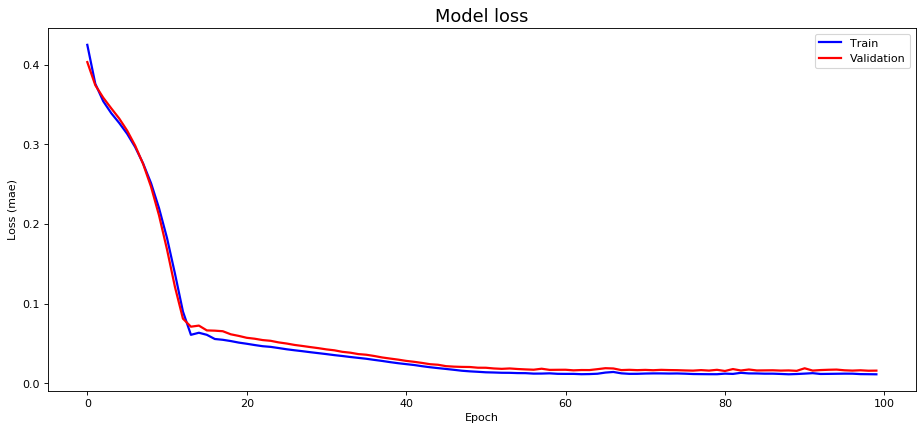

In [7]:
#Plotting training and validation loss for model
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history1['loss'], 'b', label='Train', linewidth=2)
ax.plot(history1['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

2/2 [==============================] - 0s 2ms/step
Threshold Value: 0.02144266522600797
2/2 [==============================] - 0s 2ms/step


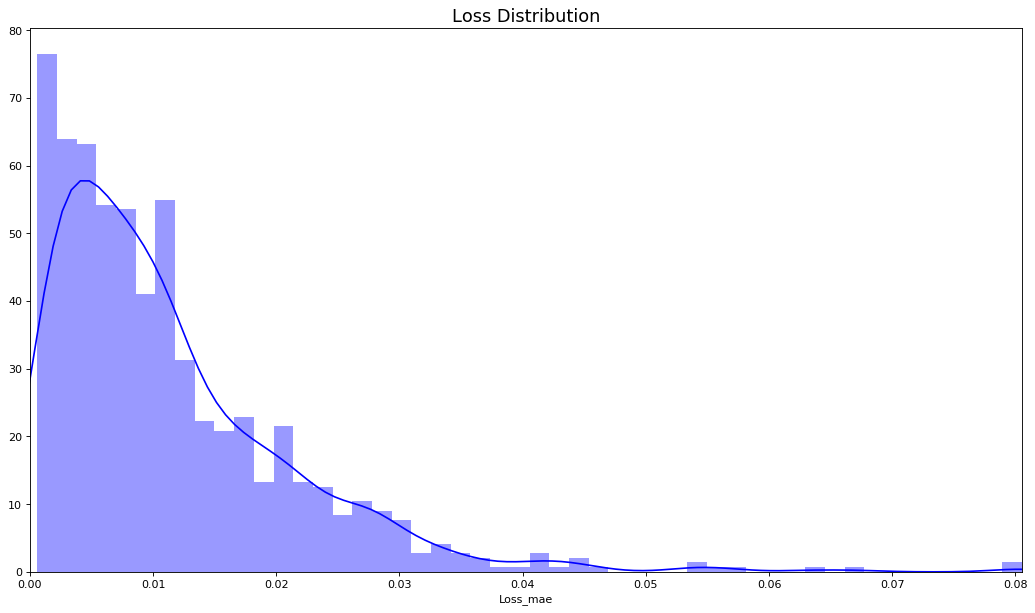

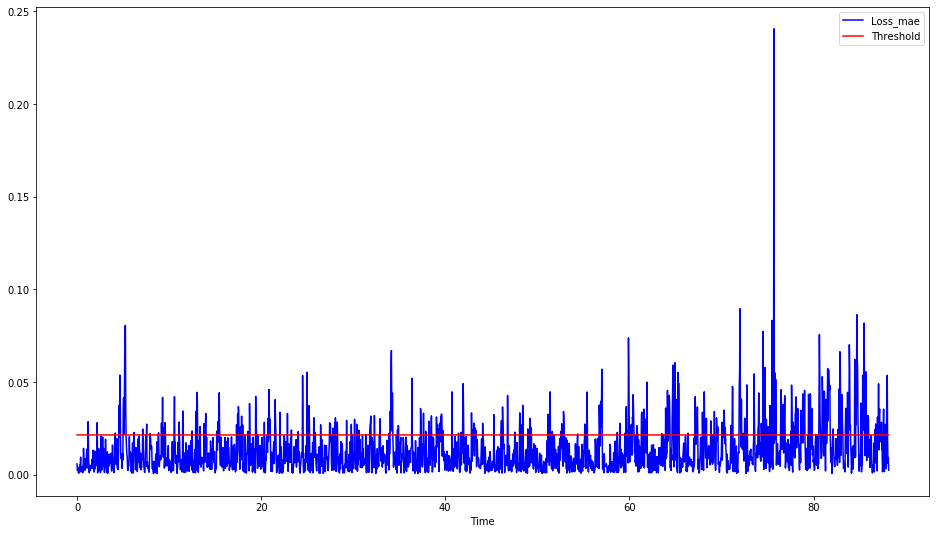

In [8]:
# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
X_pred1 = model4.predict(train)
X_pred1 = X_pred1.reshape(X_pred1.shape[0]*X_pred1.shape[1], X_pred1.shape[2])
X_pred1 = pd.DataFrame(X_pred1, columns=data.columns[1:4])
X_pred1.index = data.iloc[0:int(0.4*len(data)),0]

scored1 = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
Xtrain1 = train.reshape(train.shape[0]*train.shape[1], train.shape[2])
scored1['Loss_mae'] = np.mean(np.abs(X_pred1-Xtrain1), axis = 1)
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_reg = np.mean(scored1['Loss_mae']) + np.std(scored1['Loss_mae'])
print(f'Threshold Value: {thresh_reg}')

#Computing test set loss and applying threshold value for anomaly detection
X_pred1 = model4.predict(test)
X_pred1 = X_pred1.reshape(X_pred1.shape[0]*X_pred1.shape[1], X_pred1.shape[2])
X_pred1 = pd.DataFrame(X_pred1, columns=data.columns[1:4])
X_pred1.index = data.iloc[(int(0.4*len(data))):,0]

scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
Xtest1 = test.reshape(test.shape[0]*test.shape[1], test.shape[2])
scored1['Loss_mae'] = np.mean(np.abs(X_pred1-Xtest1), axis = 1)
scored1['Threshold'] = thresh_reg
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

#Computing train set loss and applying threshold value
X_pred1_train = model4.predict(train)
X_pred1_train = X_pred1_train.reshape(X_pred1_train.shape[0]*X_pred1_train.shape[1], X_pred1_train.shape[2])
X_pred1_train = pd.DataFrame(X_pred1_train, columns=data.columns[1:4])
X_pred1_train.index = data.iloc[0:int(0.4*len(data)),0]

scored1_train = pd.DataFrame(index= data.iloc[0:int(0.4*len(data)),0])
Xtrain1 = train.reshape(train.shape[0]*train.shape[1], train.shape[2])
scored1_train['Loss_mae'] = np.mean(np.abs(X_pred1_train-Xtrain1), axis = 1)
scored1_train['Threshold'] = thresh_reg
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

#Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in period preceding anomalous turbulence
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])

As there is some noise in the normal turbulence data, a few values in the test set that represent normal turbulence have MAE's that exceed the anomaly detection threshold.

## Getting this to run on a microcontroller

### Saving TensorFlow model to identify size and compression factor

In [9]:
#Saving Tensorflow Model in Protocol Buffer Format
model4.save("model4")

INFO:tensorflow:Assets written to: model4/assets


### Define function to export C Array from TFLite model

In [10]:
# Function: Convert some hex value into an array for C programming
def hex_to_c_array(hex_data, var_name):

    c_str = ''

  # Create header guard
    c_str += '#ifndef ' + var_name.upper() + '_H\n'
    c_str += '#define ' + var_name.upper() + '_H\n\n'

  # Add array length at top of file
    c_str += '\nunsigned int ' + var_name + '_len = ' + str(len(hex_data)) + ';\n'

  # Declare C variable
    c_str += 'unsigned char ' + var_name + '[] = {'
    hex_array = []
    for i, val in enumerate(hex_data) :

    # Construct string from hex
        hex_str = format(val, '#04x')

    # Add formatting so each line stays within 80 characters
        if (i + 1) < len(hex_data):
            hex_str += ','
        if (i + 1) % 12 == 0:
            hex_str += '\n '
        hex_array.append(hex_str)

  # Add closing brace
    c_str += '\n ' + format(' '.join(hex_array)) + '\n};\n\n'

  # Close out header guard
    c_str += '#endif //' + var_name.upper() + '_H'

    return c_str

#### Converting model to TFLite, then C array by first fixing the input size using a concrete function then converting from saved model

In [11]:
run_model = tf.function(lambda x: model4(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 15
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model4.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
model4.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)
# converter.optimizations =  [tf.lite.Optimize.DEFAULT]
tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=tflite_model)

#Saving models
with open('model4.tflite', 'wb') as f:
    f.write(tflite_model)
    
with open('c_model4' + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model, 'c_model4'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets
=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #5 and tensor #2 as input and produces tensor #9 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 FULLY_CONNECTED(T#0, T#5, T#2) -> [T#9]
  Op#1 FULLY_CONNECTED(T#9, T#6, T#4) -> [T#10]
  Op#2 FULLY_CONNECTED(T#10, T#7, T#3) -> [T#11]
  Op#3 FULLY_CONNECTED(T#11, T#8, T#1) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 15, 3], type:FLOAT32
  T#1(sequential/output/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes
  T#2(sequential/dense/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#3(sequential/dense_2/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#4(sequential/dense_1/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes
  T#5(sequential/de

#### Alternative Converting model to TFLite, then C array

In [12]:
#Converting models to tflite models
converter_alt = tf.lite.TFLiteConverter.from_keras_model(model4)

# converter_alt.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS, tf.lite.OpsSet.SELECT_TF_OPS]
# converter_alt._experimental_lower_tensor_list_ops = False
# converter_alt.optimizations =  [tf.lite.Optimize.DEFAULT]
tflite_model_alt = converter_alt.convert()

tf.lite.experimental.Analyzer.analyze(model_content=tflite_model_alt)

#Saving models
with open('model_alt_4.tflite', 'wb') as f:
    f.write(tflite_model_alt)

with open('c_model_alt_4' + '.h', 'w') as file:
    file.write(hex_to_c_array(tflite_model_alt, 'c_model_alt_4'))

INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmp63uadlpj/assets
=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the SHAPE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#58]
  Op#0 SHAPE(T#0) -> [T#15]
  Op#1 GATHER(T#15, T#6) -> [T#16]
  Op#2 REDUCE_PROD(T#16, T#8) -> [T#17]
  Op#3 GATHER(T#15, T#5) -> [T#18]
  Op#4 REDUCE_PROD(T#18, T#8) -> [T#19]
  Op#5 PACK(T#19, T#17) -> [T#20]
  Op#6 CONCATENATION(T#18, T#9) -> [T#21]
  Op#7 RESHAPE(T#0, T#20) -> [T#22]
  Op#8 FULLY_CONNECTED(T#22, T#11, T#-1) -> [T#23]
  Op#9 RESHAPE(T#23, T#21) -> [T#24]
  Op#10 ADD(T#24, T#2) -> [T#25]
  Op#11 SHAPE(T#25) -> [T#26]
  Op#12 GATHER(T#26, T#5) -> [T#27]
  Op#13 REDUCE_PROD(T#27, T#8) -> [T#28]
  Op#14 CONCATENATION(T#27, T#10) -> [T#29]
  Op#15 GATHER(T#26, T#6) -> [T#30]
  Op#16 REDUCE_PROD(T#30, T#

## Quantization Aware Training with Integer Quantization

In [13]:
quantize_model = tfmot.quantization.keras.quantize_model

# q_aware stands for for quantization aware.
q_aware_model = quantize_model(model4)

# `quantize_model` requires a recompile.
q_aware_model.compile(optimizer='adam',
              loss='mae')

q_aware_model.summary()

# Fitting model to the data
nb_epochs = 100
batch_size = 10
history1 = q_aware_model.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 quantize_layer (QuantizeLay  (None, 15, 3)            3         
 er)                                                             
                                                                 
 quant_dense (QuantizeWrappe  (None, 15, 32)           133       
 rV2)                                                            
                                                                 
 quant_dense_1 (QuantizeWrap  (None, 15, 8)            269       
 perV2)                                                          
                                                                 
 quant_dense_2 (QuantizeWrap  (None, 15, 32)           293       
 perV2)                                                          
                                                                 
 quant_output (QuantizeWrapp  (None, 15, 3)            1

6/6 [==============================] - 0s 5ms/step - loss: 0.0143 - val_loss: 0.0151
Epoch 71/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0147 - val_loss: 0.0142
Epoch 72/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0157
Epoch 73/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0146 - val_loss: 0.0160
Epoch 74/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0143 - val_loss: 0.0148
Epoch 75/100
6/6 [==============================] - 0s 6ms/step - loss: 0.0145 - val_loss: 0.0154
Epoch 76/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0139 - val_loss: 0.0145
Epoch 77/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0139 - val_loss: 0.0145
Epoch 78/100
6/6 [==============================] - 0s 7ms/step - loss: 0.0138 - val_loss: 0.0146
Epoch 79/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0136 - val_loss: 0.0140
Epoch 80/100
6/6 [===============

In [14]:
def representative_data_gen():
    vals = tf.data.Dataset.from_tensor_slices(train).batch(1)
    for i in vals.take(100):#batch size
        i = tf.dtypes.cast(i, tf.float32)
        yield [i]

In [15]:
run_model = tf.function(lambda x: q_aware_model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 15
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], q_aware_model.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
q_aware_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)

converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
converter.optimizations = [tf.lite.Optimize.DEFAULT]
quantized_tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=quantized_tflite_model)

#Saving models
with open('model4_qai.tflite', 'wb') as f:
    f.write(quantized_tflite_model)
    
with open('c_model4_qai' + '.h', 'w') as file:
    file.write(hex_to_c_array(quantized_tflite_model, 'c_model4_qai'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets


INFO:tensorflow:Assets written to: anomaly_det_mod/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #3 as output.

Subgraph#0 main(T#0) -> [T#18]
  Op#0 QUANTIZE(T#0) -> [T#3]
  Op#1 RESHAPE(T#3, T#1) -> [T#4]
  Op#2 FULLY_CONNECTED(T#4, T#5, T#6) -> [T#7]
  Op#3 FULLY_CONNECTED(T#7, T#8, T#9) -> [T#10]
  Op#4 FULLY_CONNECTED(T#10, T#11, T#12) -> [T#13]
  Op#5 FULLY_CONNECTED(T#13, T#14, T#15) -> [T#16]
  Op#6 RESHAPE(T#16, T#2) -> [T#17]
  Op#7 DEQUANTIZE(T#17) -> [T#18]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 15, 3], type:FLOAT32
  T#1(sequential/quant_dense/Tensordot/Reshape/shape) shape:[2], type:INT32 RO 8 bytes
  T#2(sequential/quant_output/Tensordot/shape) shape:[3], type:INT32 RO 12 bytes
  T#3(tfl.quantize) shape:[1, 15, 3], type:INT8
  T#4(sequential/quant_dense/Tensordot/Reshape;sequential/quantize_layer/AllValuesQuantize/FakeQuan

In [65]:
converter = tf.lite.TFLiteConverter.from_keras_model(q_aware_model)
converter.representative_dataset = representative_data_gen
converter.optimizations = [tf.lite.Optimize.DEFAULT]

converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # Set the input and output tensors to uint8 (APIs added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

quantized_tflite_model_alt = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=quantized_tflite_model_alt)


#Saving models
with open('model_alt_4_qai.tflite', 'wb') as f:
    f.write(quantized_tflite_model_alt)

with open('c_model_alt_4_qai' + '.h', 'w') as file:
    file.write(hex_to_c_array(quantized_tflite_model_alt, 'c_model_alt_4_qai'))

INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpv6kzi5p_/assets


INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpv6kzi5p_/assets
/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the QUANTIZE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#60]
  Op#0 QUANTIZE(T#0) -> [T#15]
  Op#1 SHAPE(T#15) -> [T#16]
  Op#2 GATHER(T#16, T#1) -> [T#17]
  Op#3 REDUCE_PROD(T#17, T#2) -> [T#18]
  Op#4 CONCATENATION(T#17, T#3) -> [T#19]
  Op#5 GATHER(T#16, T#4) -> [T#20]
  Op#6 REDUCE_PROD(T#20, T#2) -> [T#21]
  Op#7 PACK(T#18, T#21) -> [T#22]
  Op#8 RESHAPE(T#15, T#22) -> [T#23]
  Op#9 FULLY_CONNECTED(T#23, T#7, T#-1) -> [T#24]
  Op#10 RESHAPE(T#24, T#19) -> [T#25]
  Op#11 ADD(T#25, T#8) -> [T#26]
  Op#12 SHAPE(T#26) -> [T#27]
  Op#13 GATHER(T#27, T#1) -> [T#28]
  Op#14 REDUCE_PROD(T#28, T#2) -> [T#29]
  Op#15 CONCATENATION(T#28, T#5) -> [T#30]
  Op#16 GATHER(T#27, T#4) -> [T#31]
  Op#17 REDUCE_PROD(T#31, T#2) -> [T#32]
  Op#18 PACK(T#29, T#32) -> [T#33]
  Op#19 RESHAPE(T#26

### Model Loss Plots

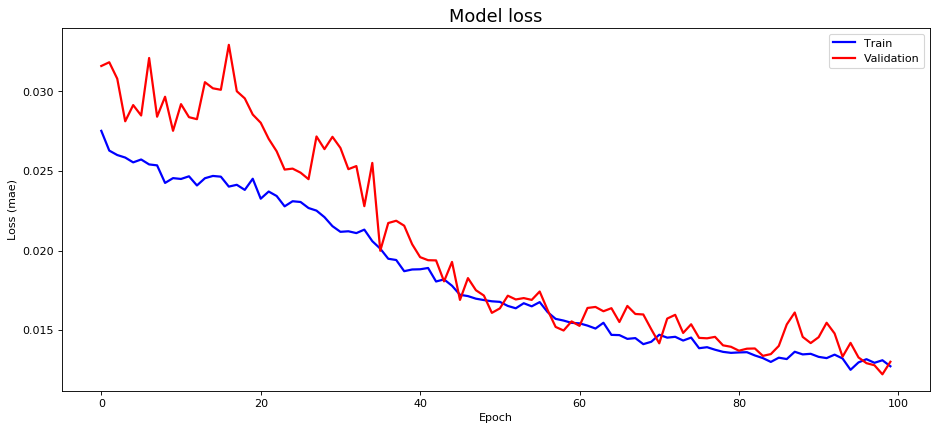

In [17]:
#Plotting training and validation loss for model
fig, ax = plt.subplots(figsize=(14, 6), dpi=80)
ax.plot(history1['loss'], 'b', label='Train', linewidth=2)
ax.plot(history1['val_loss'], 'r', label='Validation', linewidth=2)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mae)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

Threshold Value: 0.018009565468414278


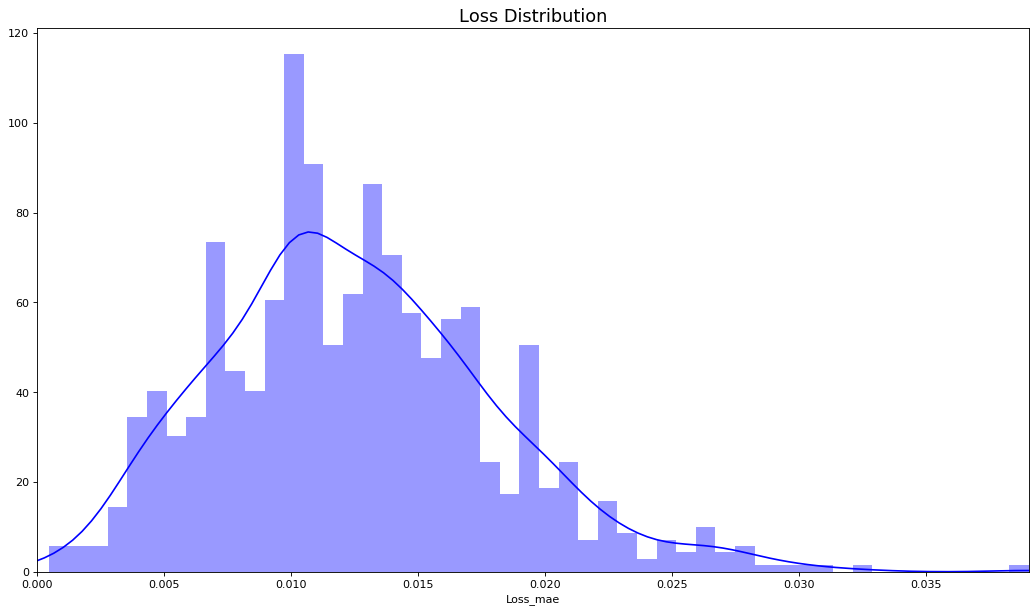

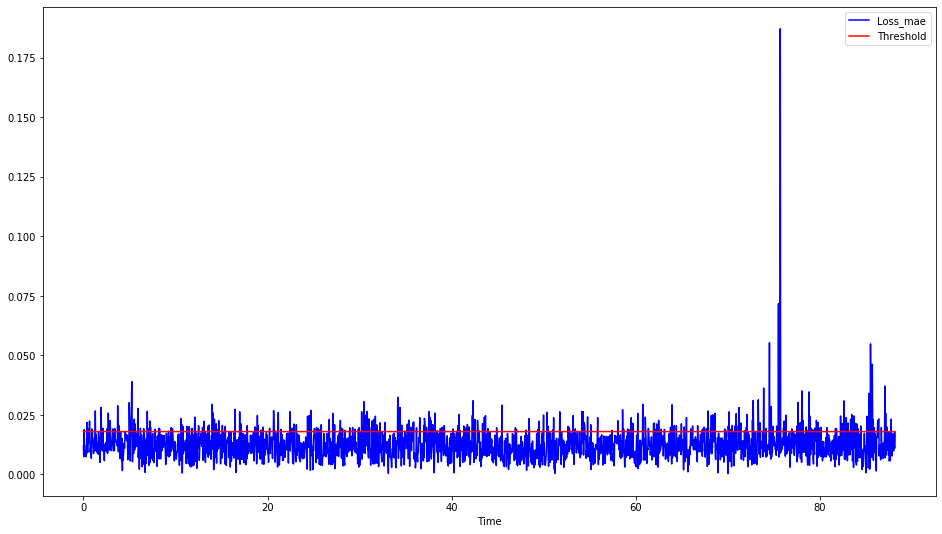

In [18]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result
    
tfl1_pred = tfl1_pred.reshape(900,3)
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train.reshape(900,3)), axis = 1)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_qai = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_qai}')

#Applying threshold value
scored1_train['Threshold'] = thresh_qai
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result

tfl1_pred = tfl1_pred.reshape(1350,3)

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test.reshape(1350,3)), axis = 1)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_qai
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


Threshold Value: 0.01843401631563169


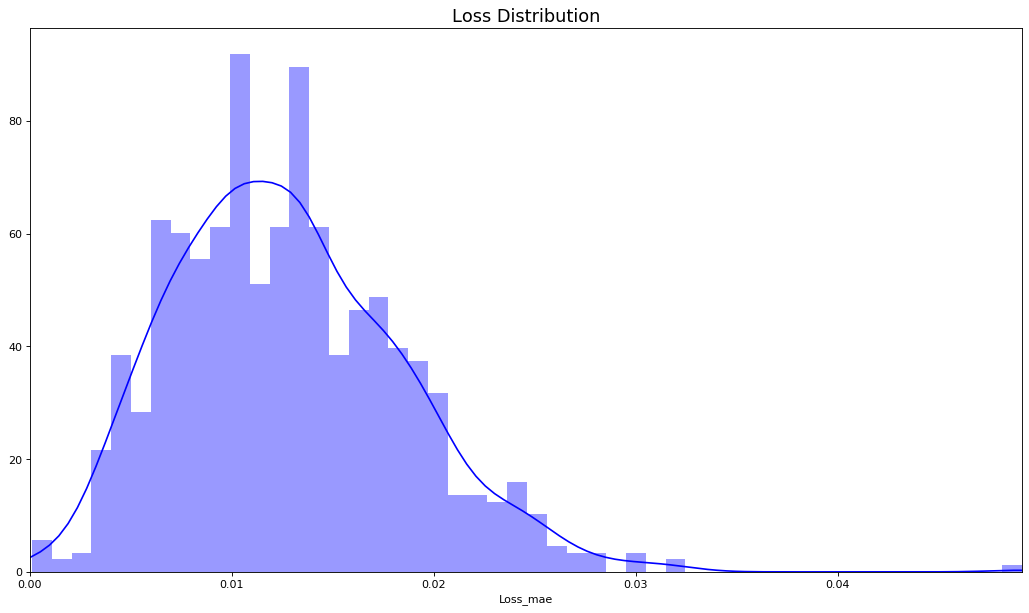

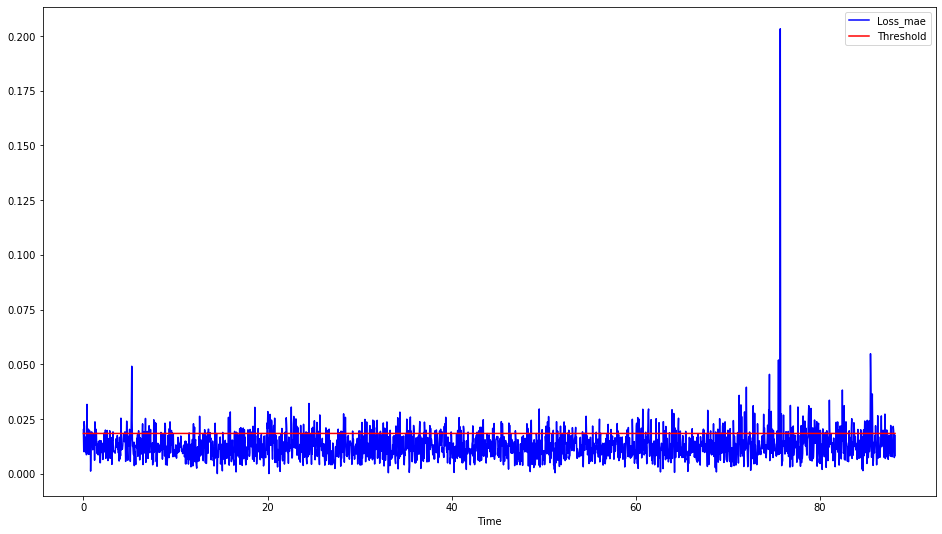

In [19]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=quantized_tflite_model_alt)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result
    
tfl1_pred = tfl1_pred.reshape(900,3)
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train.reshape(900,3)), axis = 1)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_qai_alt = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_qai_alt}')

#Applying threshold value
scored1_train['Threshold'] = thresh_qai_alt
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result

tfl1_pred = tfl1_pred.reshape(1350,3)

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test.reshape(1350,3)), axis = 1)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_qai_alt
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


In [20]:
def train_loss(model):
    # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl1_pred = np.empty((900,1,3))
    for i in range(len(train)):
        interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl1_pred[i*15:(i+1)*15,0,:] = result
    tfl1_pred = tfl1_pred.reshape(900,3)
    return np.mean(np.abs(tfl1_pred - train.reshape(900,3)))

In [21]:
# train_loss(quantized_tflite_model) == train_loss(quantized_tflite_model_alt)
train_loss(quantized_tflite_model)
train_loss(quantized_tflite_model_alt)

0.012743832575171081

In [22]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

#Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result

In [23]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=tflite_model_alt)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

#Predictions from TFLite model
tfl2_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl2_pred[i*15: (i+1)*15,0,:] = result

In [24]:
np.all(tfl1_pred == tfl2_pred)

True

In [25]:
tfl2_pred.shape

(1350, 1, 3)

## Weight Clustering

In [26]:
import tempfile
import zipfile
import os

In [27]:
_, keras_file = tempfile.mkstemp('.h5')
print('Saving model to: ', keras_file)
tf.keras.models.save_model(model4, keras_file, include_optimizer=False)

Saving model to:  /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmp6t7osfta.h5


In [28]:
#Autoencoder with three dense layers and dropout
model4 = tf.keras.models.Sequential([
    Input(shape=(train.shape[1], train.shape[2]), name="input"),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train.shape[2], name = 'output'),
])


model4.compile(optimizer='adam', loss='mae')
model4.summary()

# Fitting model to the data
nb_epochs = 100
batch_size = 10
history1 = model4.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

cluster_weights = tfmot.clustering.keras.cluster_weights
CentroidInitialization = tfmot.clustering.keras.CentroidInitialization

clustering_params = {
  'number_of_clusters': 32,
  'cluster_centroids_init': CentroidInitialization.KMEANS_PLUS_PLUS
}

# Cluster a whole model
clustered_model = cluster_weights(model4, **clustering_params)

# Use smaller learning rate for fine-tuning clustered model
opt = tf.keras.optimizers.Adam(learning_rate=1e-5)

clustered_model.compile(
  loss='mae',
  optimizer=opt)

clustered_model.summary()

# Fine-tune model
clustered_model.fit(train, train, epochs=20, batch_size=128,
                    validation_split=0.05)

clustered_model = tfmot.clustering.keras.strip_clustering(clustered_model)

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 15, 32)            128       
                                                                 
 dense_4 (Dense)             (None, 15, 8)             264       
                                                                 
 dense_5 (Dense)             (None, 15, 32)            288       
                                                                 
 output (Dense)              (None, 15, 3)             99        
                                                                 
Total params: 779
Trainable params: 779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 1s 36ms/step - loss: 0.3599 - val_loss: 0.3602
Epoch 2/100
6/6 [==============================] - 0s 5ms/step - loss: 0.3429 - val_loss: 

6/6 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.0257
Epoch 76/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0193 - val_loss: 0.0268
Epoch 77/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0184 - val_loss: 0.0238
Epoch 78/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0182 - val_loss: 0.0257
Epoch 79/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.0240
Epoch 80/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0178 - val_loss: 0.0233
Epoch 81/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0170 - val_loss: 0.0224
Epoch 82/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0164 - val_loss: 0.0224
Epoch 83/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0162 - val_loss: 0.0220
Epoch 84/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0161 - val_loss: 0.0223
Epoch 85/100
6/6 [===============

In [29]:
_, clustered_keras_file = tempfile.mkstemp('.h5')
print('Saving clustered model to: ', clustered_keras_file)
tf.keras.models.save_model(clustered_model, clustered_keras_file, 
                           include_optimizer=False)

Saving clustered model to:  /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmp0c3vaa0g.h5


In [30]:
run_model = tf.function(lambda x: clustered_model(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 15
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], clustered_model.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
clustered_model.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)

# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
clustered_tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=clustered_tflite_model)

#Saving models
with open('model4_clust.tflite', 'wb') as f:
    f.write(clustered_tflite_model)
    
with open('c_model4_clust' + '.h', 'w') as file:
    file.write(hex_to_c_array(clustered_tflite_model, 'c_model4_clust'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets


INFO:tensorflow:Assets written to: anomaly_det_mod/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #5 and tensor #4 as input and produces tensor #9 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 FULLY_CONNECTED(T#0, T#5, T#4) -> [T#9]
  Op#1 FULLY_CONNECTED(T#9, T#6, T#3) -> [T#10]
  Op#2 FULLY_CONNECTED(T#10, T#7, T#2) -> [T#11]
  Op#3 FULLY_CONNECTED(T#11, T#8, T#1) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 15, 3], type:FLOAT32
  T#1(sequential_1/output/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes
  T#2(sequential_1/dense_5/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#3(sequential_1/dense_4/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes
  T#4(sequential_1/dense_3/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#5(sequential_1/dense_3/Tensordot/MatMul) shape:[32, 3], type:FL

In [31]:
converter = tf.lite.TFLiteConverter.from_keras_model(clustered_model)
# converter.representative_dataset = representative_data_gen
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # Set the input and output tensors to uint8 (APIs added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

clustered_tflite_model_alt = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=clustered_tflite_model_alt)


#Saving models
with open('model_alt_4_clust.tflite', 'wb') as f:
    f.write(clustered_tflite_model_alt)

with open('c_model_alt_4_clust' + '.h', 'w') as file:
    file.write(hex_to_c_array(clustered_tflite_model_alt, 'c_model_alt_4_clust'))

INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpf1qv07ge/assets


INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpf1qv07ge/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the SHAPE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#58]
  Op#0 SHAPE(T#0) -> [T#15]
  Op#1 GATHER(T#15, T#6) -> [T#16]
  Op#2 REDUCE_PROD(T#16, T#8) -> [T#17]
  Op#3 GATHER(T#15, T#5) -> [T#18]
  Op#4 REDUCE_PROD(T#18, T#8) -> [T#19]
  Op#5 PACK(T#19, T#17) -> [T#20]
  Op#6 CONCATENATION(T#18, T#9) -> [T#21]
  Op#7 RESHAPE(T#0, T#20) -> [T#22]
  Op#8 FULLY_CONNECTED(T#22, T#11, T#-1) -> [T#23]
  Op#9 RESHAPE(T#23, T#21) -> [T#24]
  Op#10 ADD(T#24, T#4) -> [T#25]
  Op#11 SHAPE(T#25) -> [T#26]
  Op#12 GATHER(T#26, T#5) -> [T#27]
  Op#13 REDUCE_PROD(T#27, T#8) -> [T#28]
  Op#14 CONCATENATION(T#27, T#10) -> [T#29]
  Op#15 GATHER(T#26, T#6) -> [T#30]
  Op#16 REDUCE_PROD(T#30, T#8) -> [T#31]
  Op#17 PACK(T#28, T#31) -> [T#32]
  Op#18 RESHAPE(T#25, T#32) -> [T#33]
  Op#19 FULLY_CON

In [32]:
train_loss(clustered_tflite_model)

0.01960158883811975

Threshold Value: 0.032554526325617075


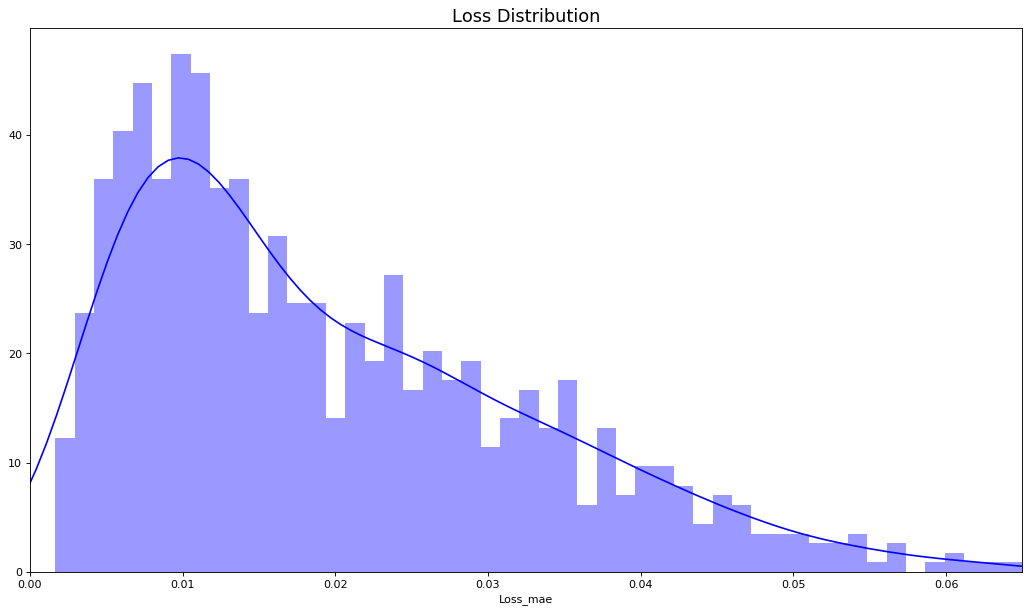

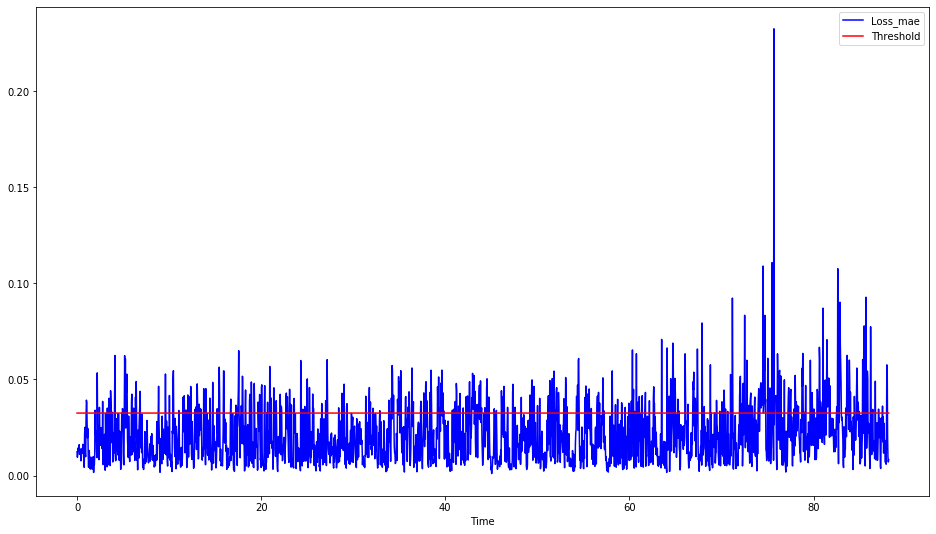

In [33]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=clustered_tflite_model)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result
    
tfl1_pred = tfl1_pred.reshape(900,3)
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train.reshape(900,3)), axis = 1)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_clust = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_clust}')

#Applying threshold value
scored1_train['Threshold'] = thresh_clust
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result

tfl1_pred = tfl1_pred.reshape(1350,3)

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test.reshape(1350,3)), axis = 1)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_clust
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


Threshold Value: 0.032554526325617075


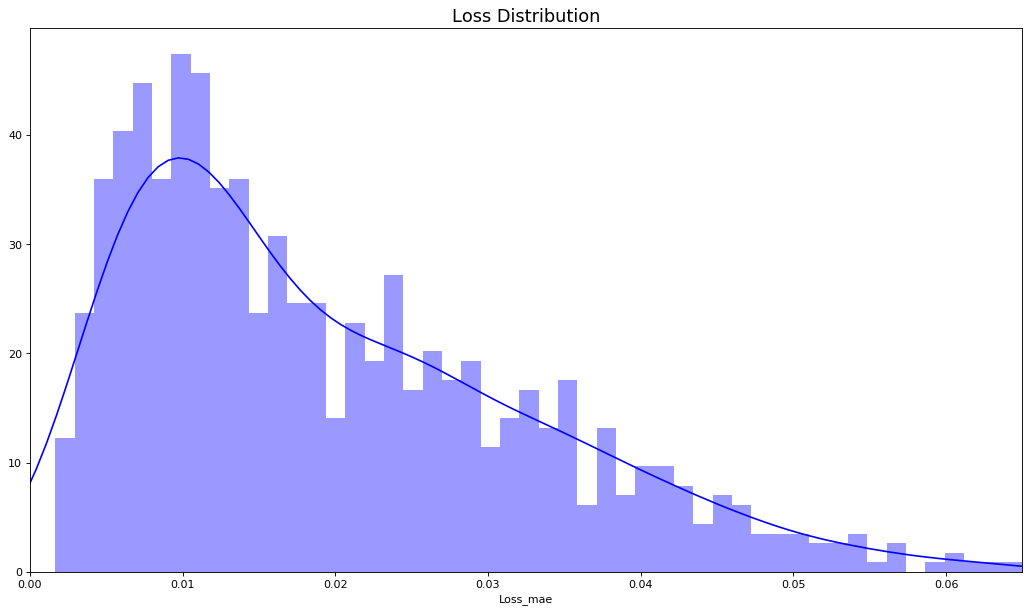

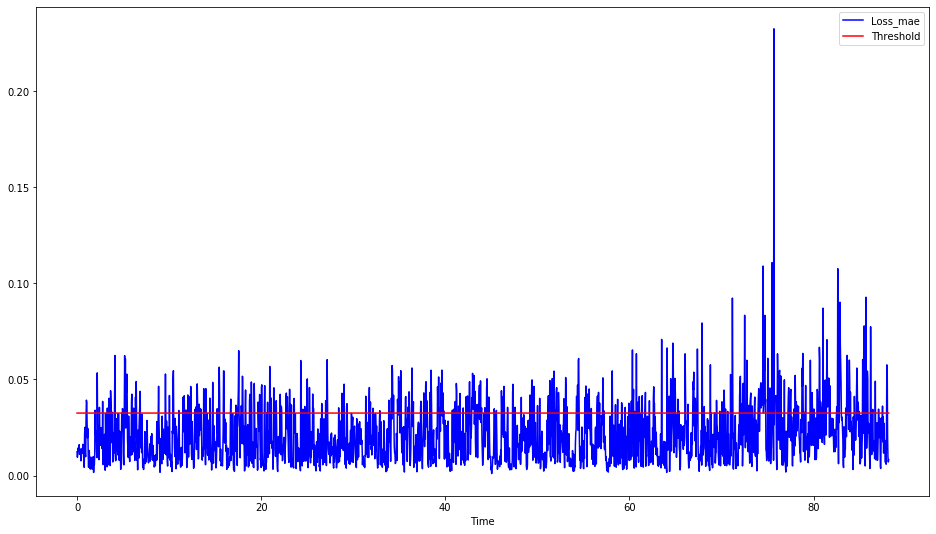

In [34]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=clustered_tflite_model_alt)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result
    
tfl1_pred = tfl1_pred.reshape(900,3)
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train.reshape(900,3)), axis = 1)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_clust_alt = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_clust_alt}')

#Applying threshold value
scored1_train['Threshold'] = thresh_clust_alt
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result

tfl1_pred = tfl1_pred.reshape(1350,3)

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test.reshape(1350,3)), axis = 1)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_clust_alt
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


In [35]:
def get_gzipped_model_size(file):
  # It returns the size of the gzipped model in bytes.
    _, zipped_file = tempfile.mkstemp('.zip')
    with zipfile.ZipFile(zipped_file, 'w', compression=zipfile.ZIP_DEFLATED) as f:
        f.write(file)
    return os.path.getsize(zipped_file)

In [36]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped clustered Keras model: %.2f bytes" % (get_gzipped_model_size(clustered_keras_file)))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size('model4_clust.tflite')))
print("Size of gzipped clustered TFlite model: %.2f bytes" % (get_gzipped_model_size('model_alt_4_clust.tflite')))

Size of gzipped baseline Keras model: 4841.00 bytes
Size of gzipped clustered Keras model: 3149.00 bytes
Size of gzipped clustered TFlite model: 2512.00 bytes
Size of gzipped clustered TFlite model: 4439.00 bytes


## Pruning

In [37]:
#Autoencoder with three dense layers and dropout
model4 = tf.keras.models.Sequential([
    Input(shape=(train.shape[1], train.shape[2]), name="input"),
    Dense(32, activation='relu'),
    Dense(8, activation='relu'),
    Dense(32, activation='relu'),
    Dense(train.shape[2], name = 'output'),
])


model4.compile(optimizer='adam', loss='mae')
model4.summary()

# Fitting model to the data
nb_epochs = 100
batch_size = 10
history1 = model4.fit(train, train, epochs=nb_epochs, batch_size=batch_size,
                    validation_split=0.05).history

prune_low_magnitude = tfmot.sparsity.keras.prune_low_magnitude

# Compute end step to finish pruning after 2 epochs.
batch_size = 128
epochs = 20
validation_split = 0.05 # 5% of training set will be used for validation set. 

num_train = train.shape[0] * (1 - validation_split)
end_step = np.ceil(num_train / batch_size).astype(np.int32) * epochs

# Define model for pruning.
pruning_params = {
      'pruning_schedule': tfmot.sparsity.keras.PolynomialDecay(initial_sparsity=0.50,
                                                               final_sparsity=0.75,
                                                               begin_step=0,
                                                               end_step=end_step)
}

model_for_pruning = prune_low_magnitude(model4, **pruning_params)

# `prune_low_magnitude` requires a recompile.
model_for_pruning.compile(optimizer='adam',
              loss='mae')

model_for_pruning.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_6 (Dense)             (None, 15, 32)            128       
                                                                 
 dense_7 (Dense)             (None, 15, 8)             264       
                                                                 
 dense_8 (Dense)             (None, 15, 32)            288       
                                                                 
 output (Dense)              (None, 15, 3)             99        
                                                                 
Total params: 779
Trainable params: 779
Non-trainable params: 0
_________________________________________________________________
Epoch 1/100
6/6 [==============================] - 1s 40ms/step - loss: 0.3196 - val_loss: 0.3218
Epoch 2/100
6/6 [==============================] - 0s 6ms/step - loss: 0.3028 - val_loss: 

6/6 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0236
Epoch 76/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0163 - val_loss: 0.0235
Epoch 77/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0159 - val_loss: 0.0225
Epoch 78/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0156 - val_loss: 0.0232
Epoch 79/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0155 - val_loss: 0.0223
Epoch 80/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0152 - val_loss: 0.0215
Epoch 81/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0145 - val_loss: 0.0212
Epoch 82/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0144 - val_loss: 0.0218
Epoch 83/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0150 - val_loss: 0.0217
Epoch 84/100
6/6 [==============================] - 0s 5ms/step - loss: 0.0146 - val_loss: 0.0208
Epoch 85/100
6/6 [===============

/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:218: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:225: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  aggregation=tf.VariableAggregation.MEAN)
/Users/akshay/opt/anaconda3/lib/python3.7/site-packages/tensorflow_model_optimization/python/core/sparsity/keras/pruning_wrapper.py:238: UserWarning: `layer.add_variable` is deprecated and will be removed in a future version. Please use the `layer.add_weight()` method instead.
  trainable=False)


Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 prune_low_magnitude_dense_6  (None, 15, 32)           226       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_7  (None, 15, 8)            522       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_dense_8  (None, 15, 32)           546       
  (PruneLowMagnitude)                                            
                                                                 
 prune_low_magnitude_output   (None, 15, 3)            197       
 (PruneLowMagnitude)                                             
                                                                 
Total params: 1,491
Trainable params: 779
Non-trainabl

In [38]:
model_for_export = tfmot.sparsity.keras.strip_pruning(model_for_pruning)

_, pruned_keras_file = tempfile.mkstemp('.h5')
tf.keras.models.save_model(model_for_export, pruned_keras_file, include_optimizer=False)
print('Saved pruned Keras model to:', pruned_keras_file)

Saved pruned Keras model to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpoaft9awt.h5


In [39]:
run_model = tf.function(lambda x: model_for_export(x))
# This is important, let's fix the input size.
BATCH_SIZE = 1
STEPS = 15
INPUT_SIZE = 3
concrete_func = run_model.get_concrete_function(
    tf.TensorSpec([BATCH_SIZE, STEPS, INPUT_SIZE], model_for_export.inputs[0].dtype))

# model directory.
MODEL_DIR = "anomaly_det_mod"
model_for_export.save(MODEL_DIR, save_format="tf", signatures=concrete_func)

converter = tf.lite.TFLiteConverter.from_saved_model(MODEL_DIR)

# converter.representative_dataset = representative_data_gen
# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.optimizations = [tf.lite.Optimize.DEFAULT]
pruned_tflite_model = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=pruned_tflite_model)

#Saving models
with open('model4_prune.tflite', 'wb') as f:
    f.write(pruned_tflite_model)
    
with open('c_model4_prune' + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model, 'c_model4_prune'))

INFO:tensorflow:Assets written to: anomaly_det_mod/assets


INFO:tensorflow:Assets written to: anomaly_det_mod/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the FULLY_CONNECTED op takes
tensor #0 and tensor #5 and tensor #4 as input and produces tensor #9 as output.

Subgraph#0 main(T#0) -> [T#12]
  Op#0 FULLY_CONNECTED(T#0, T#5, T#4) -> [T#9]
  Op#1 FULLY_CONNECTED(T#9, T#6, T#3) -> [T#10]
  Op#2 FULLY_CONNECTED(T#10, T#7, T#2) -> [T#11]
  Op#3 FULLY_CONNECTED(T#11, T#8, T#1) -> [T#12]

Tensors of Subgraph#0
  T#0(serving_default_x:0) shape:[1, 15, 3], type:FLOAT32
  T#1(sequential_2/output/BiasAdd/ReadVariableOp) shape:[3], type:FLOAT32 RO 12 bytes
  T#2(sequential_2/dense_8/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#3(sequential_2/dense_7/BiasAdd/ReadVariableOp) shape:[8], type:FLOAT32 RO 32 bytes
  T#4(sequential_2/dense_6/BiasAdd/ReadVariableOp) shape:[32], type:FLOAT32 RO 128 bytes
  T#5(sequential_2/dense_6/Tensordot/MatMul) shape:[32, 3], type:FL

In [40]:
converter = tf.lite.TFLiteConverter.from_keras_model(model_for_export)
# converter.representative_dataset = representative_data_gen
# converter.optimizations = [tf.lite.Optimize.DEFAULT]

# converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# # Set the input and output tensors to uint8 (APIs added in r2.3)
# converter.inference_input_type = tf.uint8
# converter.inference_output_type = tf.uint8

pruned_tflite_model_alt = converter.convert()

tf.lite.experimental.Analyzer.analyze(model_content=pruned_tflite_model_alt)

#Saving models
with open('model_alt_4_prune.tflite', 'wb') as f:
    f.write(pruned_tflite_model_alt)

with open('c_model_alt_4_prune' + '.h', 'w') as file:
    file.write(hex_to_c_array(pruned_tflite_model_alt, 'c_model_alt_4_prune'))

INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpzjdiutxw/assets


INFO:tensorflow:Assets written to: /var/folders/1r/0cfhtmmn3wq09jmz6bld12pw0000gn/T/tmpzjdiutxw/assets


=== TFLite ModelAnalyzer ===

Your TFLite model has '1' subgraph(s). In the subgraph description below,
T# represents the Tensor numbers. For example, in Subgraph#0, the SHAPE op takes
tensor #0 as input and produces tensor #15 as output.

Subgraph#0 main(T#0) -> [T#58]
  Op#0 SHAPE(T#0) -> [T#15]
  Op#1 GATHER(T#15, T#6) -> [T#16]
  Op#2 REDUCE_PROD(T#16, T#8) -> [T#17]
  Op#3 GATHER(T#15, T#5) -> [T#18]
  Op#4 REDUCE_PROD(T#18, T#8) -> [T#19]
  Op#5 PACK(T#19, T#17) -> [T#20]
  Op#6 CONCATENATION(T#18, T#9) -> [T#21]
  Op#7 RESHAPE(T#0, T#20) -> [T#22]
  Op#8 FULLY_CONNECTED(T#22, T#11, T#-1) -> [T#23]
  Op#9 RESHAPE(T#23, T#21) -> [T#24]
  Op#10 ADD(T#24, T#4) -> [T#25]
  Op#11 SHAPE(T#25) -> [T#26]
  Op#12 GATHER(T#26, T#5) -> [T#27]
  Op#13 REDUCE_PROD(T#27, T#8) -> [T#28]
  Op#14 CONCATENATION(T#27, T#10) -> [T#29]
  Op#15 GATHER(T#26, T#6) -> [T#30]
  Op#16 REDUCE_PROD(T#30, T#8) -> [T#31]
  Op#17 PACK(T#28, T#31) -> [T#32]
  Op#18 RESHAPE(T#25, T#32) -> [T#33]
  Op#19 FULLY_CON

In [41]:
train_loss(pruned_tflite_model)

0.014030460826086777

Threshold Value: 0.026536583327839057


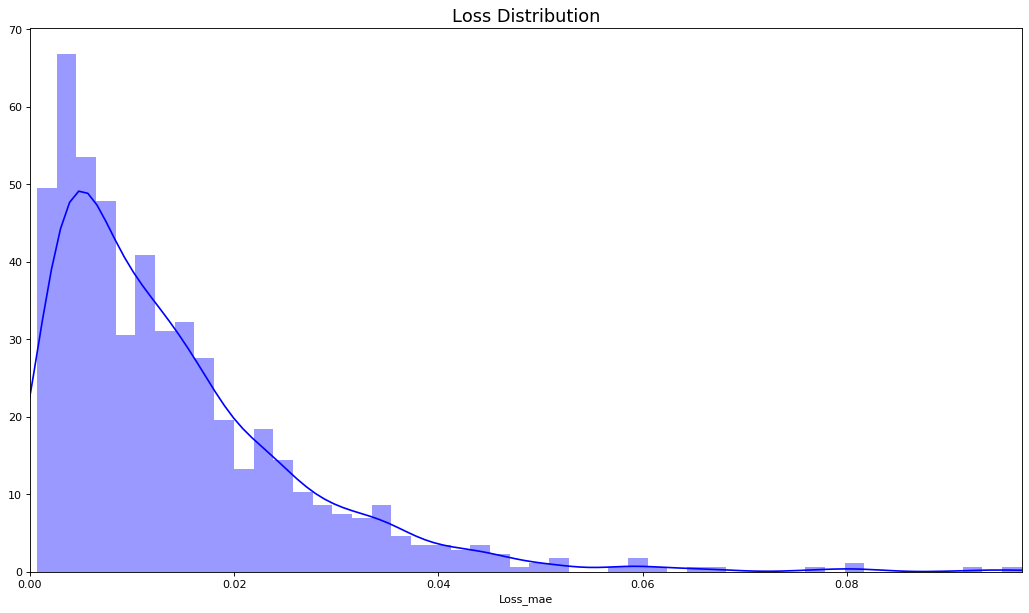

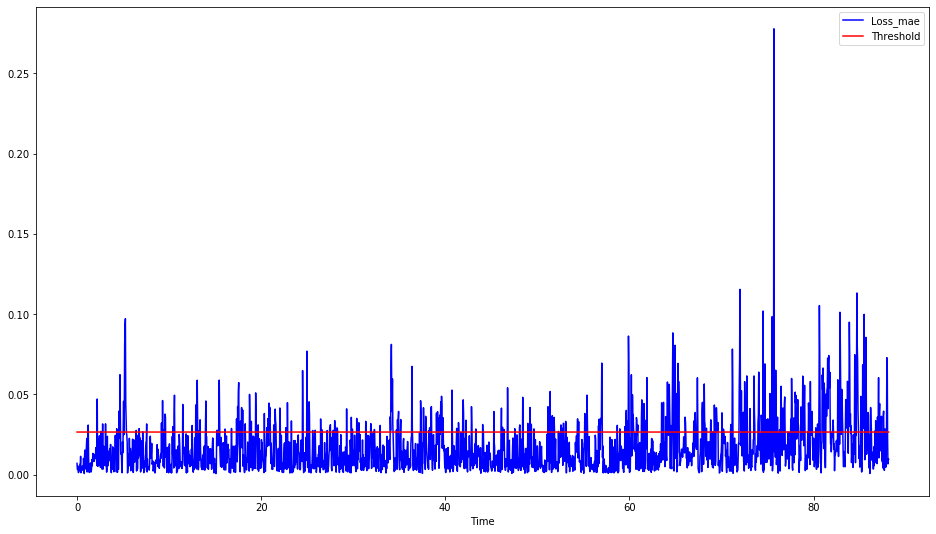

In [42]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result
    
tfl1_pred = tfl1_pred.reshape(900,3)
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train.reshape(900,3)), axis = 1)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_prune = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_prune}')

#Applying threshold value
scored1_train['Threshold'] = thresh_prune
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result

tfl1_pred = tfl1_pred.reshape(1350,3)

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test.reshape(1350,3)), axis = 1)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_prune
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


Threshold Value: 0.026536583327839057


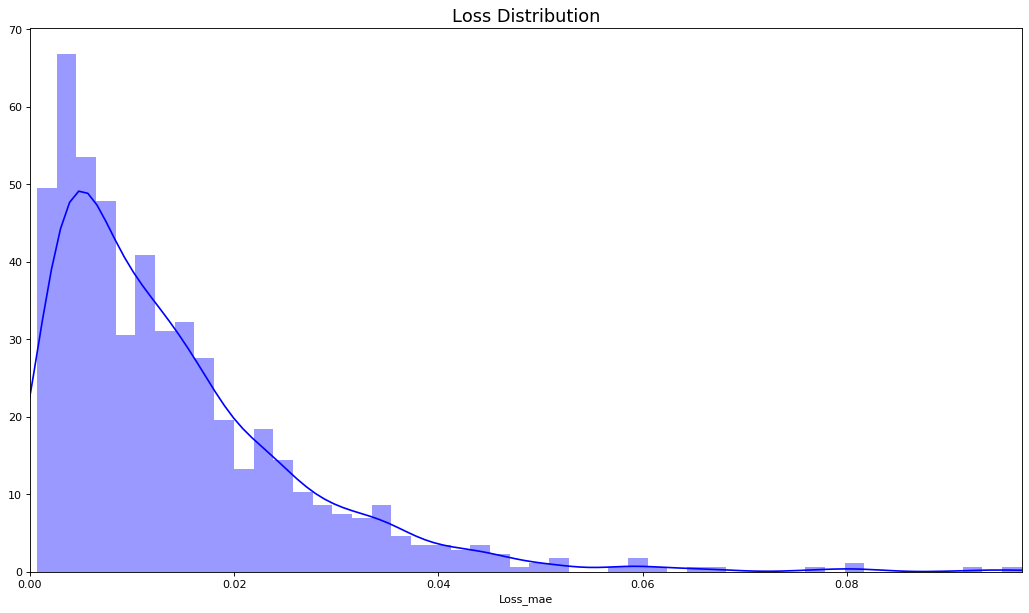

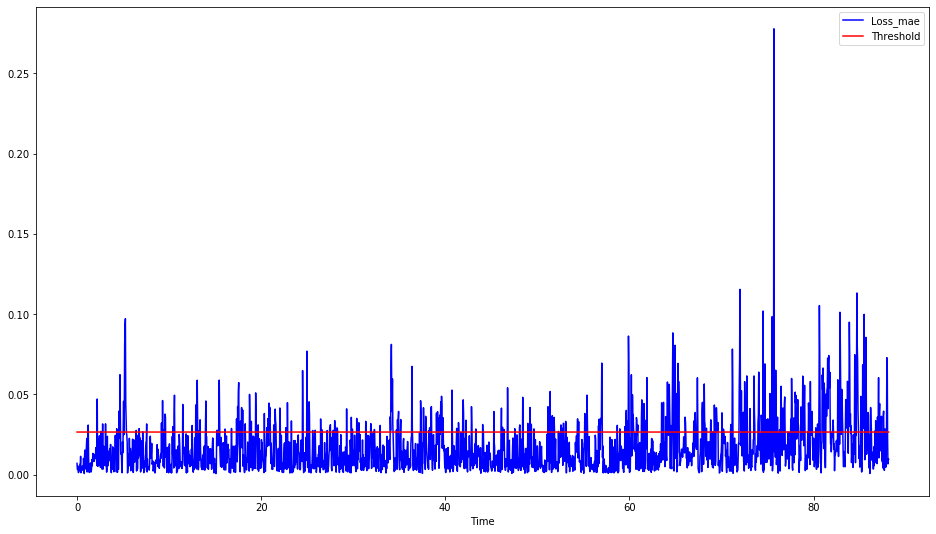

In [43]:
# Run the model with TensorFlow Lite
interpreter = tf.lite.Interpreter(model_content=pruned_tflite_model_alt)
input_details = interpreter.get_input_details()
interpreter.allocate_tensors()
output_details = interpreter.get_output_details()

# Train Predictions from TFLite model
tfl1_pred = np.empty((900,1,3))
for i in range(len(train)):
    interpreter.set_tensor(input_details[0]["index"], train.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result
    
tfl1_pred = tfl1_pred.reshape(900,3)
    
# Computing MAE Loss across all training points
loss = np.mean(np.abs(tfl1_pred - train.reshape(900,3)), axis = 1)

# Plotting distribution of loss function to establish reasonable threshold for anomaly detection
scored1_train = pd.DataFrame(index=data.iloc[0:int(0.4*len(data)),0])
scored1_train['Loss_mae'] = loss
plt.figure(figsize=(16,9), dpi=80)
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored1_train['Loss_mae'], bins = 50, kde= True, color = 'blue');
plt.xlim([0.0,np.max(scored1_train['Loss_mae'])])

#Defining threshold values for loss anomaly detection as one standard deviation above the mean
thresh_prune_alt = np.mean(scored1_train['Loss_mae']) + np.std(scored1_train['Loss_mae'])
print(f'Threshold Value: {thresh_prune_alt}')

#Applying threshold value
scored1_train['Threshold'] = thresh_prune_alt
scored1_train['Anomaly'] = scored1_train['Loss_mae'] > scored1_train['Threshold']

# Test Predictions from TFLite model
tfl1_pred = np.empty((1350,1,3))
for i in range(len(test)):
    interpreter.set_tensor(input_details[0]["index"], test.astype('float32')[i:i+1,:,:])
    interpreter.invoke()
    result = interpreter.get_tensor(output_details[0]["index"])
    tfl1_pred[i*15: (i+1)*15,0,:] = result

tfl1_pred = tfl1_pred.reshape(1350,3)

# Computing MAE Loss across all test points
loss = np.mean(np.abs(tfl1_pred - test.reshape(1350,3)), axis = 1)
    
#Computing test set loss and applying threshold value for anomaly detection
scored1 = pd.DataFrame(index= data.iloc[(int(0.4*len(data))):,0])
scored1['Loss_mae'] = loss
scored1['Threshold'] = thresh_prune_alt
scored1['Anomaly'] = scored1['Loss_mae'] > scored1['Threshold']

##Merging train and test loss data
scored_1 = pd.concat([scored1_train, scored1])

#Visualizing model output in full period
scored_1.plot(logy=False,  figsize=(16,9), color=['blue','red'])


In [44]:
print("Size of gzipped baseline Keras model: %.2f bytes" % (get_gzipped_model_size(keras_file)))
print("Size of gzipped pruned Keras model: %.2f bytes" % (get_gzipped_model_size(pruned_keras_file)))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size('model4_prune.tflite')))
print("Size of gzipped pruned TFlite model: %.2f bytes" % (get_gzipped_model_size('model_alt_4_prune.tflite')))

Size of gzipped baseline Keras model: 4841.00 bytes
Size of gzipped pruned Keras model: 4797.00 bytes
Size of gzipped pruned TFlite model: 3915.00 bytes
Size of gzipped pruned TFlite model: 5887.00 bytes


## Anomaly Detection Two-Way Table

General Idea:
Construct two-way table of anomaly classifications on entirety of test set

In [46]:
#Label train set
train_times = data.iloc[:(int(0.4*len(data))),:]['Time']
train_labs = pd.DataFrame(data.iloc[:(int(0.4*len(data))),:]['Time'] > 60).rename(columns = {"Time":"Observed"}).reset_index(drop=True)

#Label test set as anomaly or normal
#Anomaly set will have arbitrary label True
test_times = data.iloc[(int(0.4*len(data))):,:]['Time']
test_labs = pd.DataFrame(data.iloc[(int(0.4*len(data))):,:]['Time'] > 60).rename(columns = {"Time":"Observed"}).reset_index(drop=True)

#Defining function for computing vector of predictions given TFLite model
def prediction_pipeline(model, data, thresh):
    # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl_pred = np.empty((test.shape[0]*test.shape[1],3))
    for i in range(len(test)):
        interpreter.set_tensor(input_details[0]["index"], data.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl_pred[i*15:(i+1)*15,:] = result
    
    #Threshold classification
    true = test.reshape(test.shape[0]*test.shape[1], test.shape[2])
    loss_vals = np.mean(np.abs(tfl_pred - true), axis = 1)
    pred_classes = pd.DataFrame(loss_vals > thresh).rename(columns = {0:'Pred'})
    
    #Construct single dataframe containing predicted and actual values
    results = pd.concat([pred_classes, test_labs], axis = 1)
    
    #Return the two-way table containing the 
    return results.groupby(["Pred", "Observed"]).size()


In [47]:
prediction_pipeline(quantized_tflite_model_alt, test, thresh_qai_alt)

Pred   Observed
False  False       547
       True        574
True   False        84
       True        145
dtype: int64

900

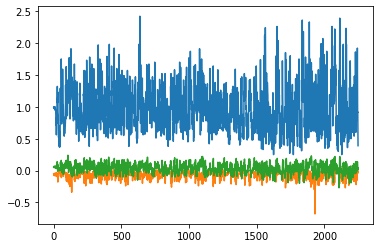

In [48]:
plt.plot(data.loc[:,('X','Y','Z')])
len(train)*15

In [49]:
def precision(results):
    values = results.values
    
    return values[3]/(values[3] + values[2])

def recall(results):
    values = results.values
    
    return values[3]/(values[3] + values[1])

def f1_score(results):
    prec = precision(results)
    rec = recall(results)
    
    return (2*prec*rec)/(prec+rec)

def accuracy(results):
    values = results.values
    
    return (values[3] + values[0])/(np.sum(values))

In [50]:
results = prediction_pipeline(tflite_model, test, thresh_reg)
results
print(f'Training Loss: {train_loss(tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.01135577575503676
Accuracy: 0.5748148148148148
Precision: 0.7361563517915309
Recall: 0.3143254520166898
F1-Score: 0.4405458089668615


In [51]:
results = prediction_pipeline(tflite_model_alt, test, thresh_reg)
results
print(f'Training Loss: {train_loss(tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.01135577575503676
Accuracy: 0.5748148148148148
Precision: 0.7361563517915309
Recall: 0.3143254520166898
F1-Score: 0.4405458089668615


In [52]:
results = prediction_pipeline(quantized_tflite_model, test, thresh_qai)
results
print(f'Training Loss: {train_loss(quantized_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.01252569540750097
Accuracy: 0.5059259259259259
Precision: 0.6181818181818182
Recall: 0.18915159944367177
F1-Score: 0.2896698615548456


In [53]:
results = prediction_pipeline(quantized_tflite_model_alt, test, thresh_qai_alt)
results
print(f'Training Loss: {train_loss(quantized_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.012743832575171081
Accuracy: 0.5125925925925926
Precision: 0.6331877729257642
Recall: 0.20166898470097358
F1-Score: 0.30590717299578063


In [54]:
results = prediction_pipeline(clustered_tflite_model, test, thresh_clust)
results
print(f'Training Loss: {train_loss(clustered_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.01960158883811975
Accuracy: 0.52
Precision: 0.6059701492537314
Recall: 0.282336578581363
F1-Score: 0.38519924098671726


In [55]:
results = prediction_pipeline(clustered_tflite_model_alt, test, thresh_clust_alt)
results
print(f'Training Loss: {train_loss(clustered_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.01960158883811975
Accuracy: 0.52
Precision: 0.6059701492537314
Recall: 0.282336578581363
F1-Score: 0.38519924098671726


In [56]:
results = prediction_pipeline(pruned_tflite_model, test, thresh_prune)
results
print(f'Training Loss: {train_loss(pruned_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.014030460826086777
Accuracy: 0.58
Precision: 0.7303030303030303
Recall: 0.33518776077885953
F1-Score: 0.459485224022879


In [57]:
results = prediction_pipeline(pruned_tflite_model_alt, test, thresh_prune_alt)
results
print(f'Training Loss: {train_loss(pruned_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.014030460826086777
Accuracy: 0.58
Precision: 0.7303030303030303
Recall: 0.33518776077885953
F1-Score: 0.459485224022879


## Anomaly Detection Voting Method

General Idea:
Batch sequences of observations into groups of 15. Conduct typical inference and anomaly detection. Create a simple batch vote schema with the voting threshold defined as one standard deviation above the mean of the number of anomaly predictions in each batch to classify all observations in the batch.

In [61]:
def voting_thresh(model, data, thresh):
        # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl_pred = np.empty((train.shape[0]*train.shape[1],3))
    for i in range(len(train)):
        interpreter.set_tensor(input_details[0]["index"], data.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl_pred[i*15:(i+1)*15,:] = result
    
    #Threshold classification
    true = train.reshape(train.shape[0]*train.shape[1], train.shape[2])
    loss_vals = np.mean(np.abs(tfl_pred - true), axis = 1)
    pred_classes = pd.DataFrame(loss_vals > thresh).rename(columns = {0:'Pred'})
    
    #Construct single dataframe containing predicted and actual predictions
    results = pd.concat([pred_classes, train_labs], axis = 1)
    
    #Voting scheme
    preds = results.values[:,0]
    batch_preds = np.resize(preds, (len(train), 15))
    votes = pd.DataFrame(batch_preds).sum(axis=1)
    voting_thresh = np.mean(votes) + np.std(votes)
    
    return voting_thresh

In [62]:
def voting_classification(model, data, thresh):
    # Run the model with TensorFlow Lite
    interpreter = tf.lite.Interpreter(model_content=model)
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()
    output_details = interpreter.get_output_details()

    #Predictions from TFLite model
    tfl_pred = np.empty((test.shape[0]*test.shape[1],3))
    for i in range(len(test)):
        interpreter.set_tensor(input_details[0]["index"], data.astype('float32')[i:i+1,:,:])
        interpreter.invoke()
        result = interpreter.get_tensor(output_details[0]["index"])
        tfl_pred[i*15:(i+1)*15,:] = result
    
    #Threshold classification
    true = test.reshape(test.shape[0]*test.shape[1], test.shape[2])
    loss_vals = np.mean(np.abs(tfl_pred - true), axis = 1)
    pred_classes = pd.DataFrame(loss_vals > thresh).rename(columns = {0:'Pred'})
    
    #Construct single dataframe containing initial predictions and actual values
    results = pd.concat([pred_classes, test_labs], axis = 1)
    
    #Voting scheme
    preds = results.values[:,0]
    batch_preds = np.resize(preds, (len(test), 15))
    votes = pd.DataFrame(batch_preds).sum(axis=1)
    voting_threshold = voting_thresh(model, train, thresh)
    voted_pred = (votes > voting_threshold)
    ind_votes = np.resize((np.array([voted_pred for i in range(15)]).T), (len(test)*15, 1))
    plt.hist(votes)
    #Construct single dataframe containing final, voted predictions and actual values
    pred_classes = pd.DataFrame(ind_votes).rename(columns = {0:'Pred'})
    results = pd.concat([pred_classes, test_labs], axis = 1)
    
    #Return the two-way table containing the 
    return results.groupby(["Pred", "Observed"]).size()
    

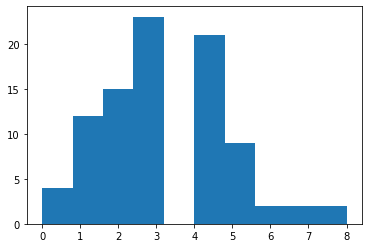

In [211]:
res = voting_classification(quantized_tflite_model_alt, test, thresh_qai_alt)

Pred   Observed
False  False       480
       True        330
True   False       151
       True        389
dtype: int64

Training Loss: 0.01135577575503676
Accuracy: 0.6992592592592592
Precision: 0.7544715447154472
Recall: 0.6453407510431154
F1-Score: 0.6956521739130435


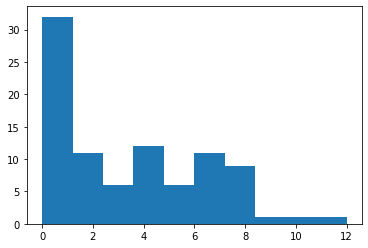

In [63]:
results = voting_classification(tflite_model, test, thresh_reg)
results
print(f'Training Loss: {train_loss(tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.009186285200784051
Accuracy: 0.7437037037037038
Precision: 0.7762962962962963
Recall: 0.7287899860917941
F1-Score: 0.7517934002869441


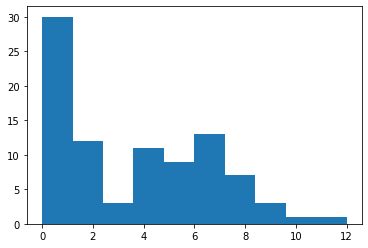

In [228]:
results = voting_classification(tflite_model_alt, test, thresh_reg)
results
print(f'Training Loss: {train_loss(tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.012218024902790784
Accuracy: 0.48962962962962964
Precision: 0.5384615384615384
Recall: 0.29207232267037553
F1-Score: 0.3787195671776375


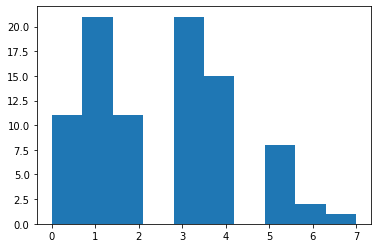

In [229]:
results = voting_classification(quantized_tflite_model, test, thresh_qai)
results
print(f'Training Loss: {train_loss(quantized_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.012026486199183594
Accuracy: 0.6437037037037037
Precision: 0.7203703703703703
Recall: 0.541029207232267
F1-Score: 0.6179507545671168


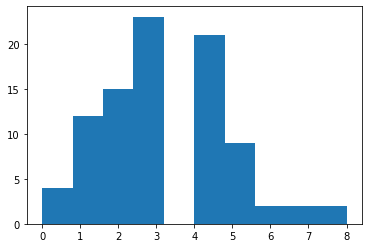

In [230]:
results = voting_classification(quantized_tflite_model_alt, test, thresh_qai_alt)
results
print(f'Training Loss: {train_loss(quantized_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.003585000449984715
Accuracy: 0.7992592592592592
Precision: 0.8733333333333333
Recall: 0.7287899860917941
F1-Score: 0.7945413191811977


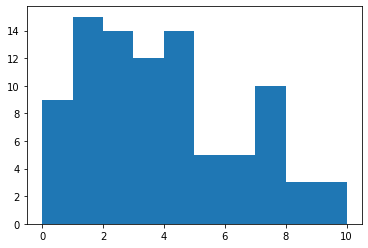

In [231]:
results = voting_classification(clustered_tflite_model, test, thresh_clust)
results
print(f'Training Loss: {train_loss(clustered_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.003585000449984715
Accuracy: 0.7992592592592592
Precision: 0.8733333333333333
Recall: 0.7287899860917941
F1-Score: 0.7945413191811977


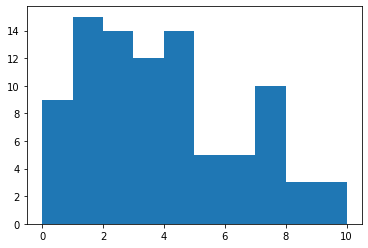

In [232]:
results = voting_classification(clustered_tflite_model_alt, test, thresh_clust_alt)
results
print(f'Training Loss: {train_loss(clustered_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.001452378190336403
Accuracy: 0.8214814814814815
Precision: 0.8064102564102564
Recall: 0.874826147426982
F1-Score: 0.839226150767178


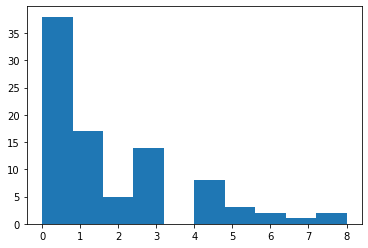

In [233]:
results = voting_classification(pruned_tflite_model, test, thresh_prune)
results
print(f'Training Loss: {train_loss(pruned_tflite_model)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')

Training Loss: 0.001452378190336403
Accuracy: 0.8214814814814815
Precision: 0.8064102564102564
Recall: 0.874826147426982
F1-Score: 0.839226150767178


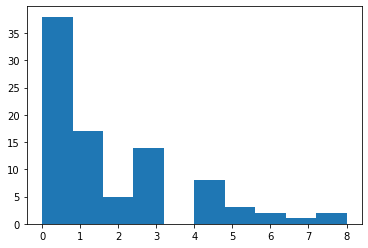

In [234]:
results = voting_classification(pruned_tflite_model_alt, test, thresh_prune_alt)
results
print(f'Training Loss: {train_loss(pruned_tflite_model_alt)}')
print(f'Accuracy: {accuracy(results)}')
print(f'Precision: {precision(results)}')
print(f'Recall: {recall(results)}')
print(f'F1-Score: {f1_score(results)}')